# User Churn Prediction

In this project, I use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
<li>[Part 5: Use Probabilities as Prediction Results](#Part-5:-Use-Probabilities-as-Prediction-Results)
</ul>

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

<ul>
<li>Data Source: https://www.sgi.com/tech/mlc/db/churn.all
<li>Data info: https://www.sgi.com/tech/mlc/db/churn.names
</ul>


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('input/churn.all')

In [2]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [3]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by churned or not
    if continuous:
        sns.boxplot(x=col_name, y='churned', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['ch'].value_counts(normalize=True)[:,1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction churned')
        ax2.set_title('churned Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'churned', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='churned', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

In [5]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [6]:
df.sample(5)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
534,LA,67,510,373-6784,no,no,0,310.4,97,52.77,66.5,123,5.65,246.5,99,11.09,9.2,10,2.48,4,False.
1473,IL,86,415,395-7435,yes,no,0,266.1,120,45.24,182.0,92,15.47,206.5,103,9.29,10.3,4,2.78,1,False.
843,AL,102,408,364-7622,no,no,0,224.7,81,38.20,129.4,112,11.00,167.6,109,7.54,15.8,6,4.27,1,False.
2268,AR,86,408,329-8115,no,yes,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0,False.
4073,MT,78,510,351-9552,no,no,0,185.8,102,31.59,251.6,88,21.39,202.8,86,9.13,13.3,6,3.59,2,False.


There are 5000 data entries, each of which has 21 features. No missing values. 

"intl_plan", "voice_mail_plan", "churned" are features with "yes/no", which can be transformed to 0/1

Next I will proceed to data cleaning and get the data ready for modeling. 

### Part 1.2: Data cleaning

First of all, I need to remove Extra Whitespace

In [7]:
df['voice_mail_plan'][0]
#df['intl_plan'][0]
#df['churned'][0]

' yes'

In [8]:
df['voice_mail_plan'] = df['voice_mail_plan'].map(lambda x: x.strip())
df['intl_plan'] = df['intl_plan'].map(lambda x: x.strip())
df['churned'] = df['churned'].map(lambda x: x.strip())

In [9]:
df['voice_mail_plan'][0]

'yes'

In [10]:
# yes/no -> 0/1
df['voice_mail_plan'] = df['voice_mail_plan'].map({'no':0, 'yes':1})
df.intl_plan = df.intl_plan.map({'no':0, 'yes':1})


In [11]:
df.sample(5)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
1974,KY,113,408,403-2673,0,1,20,157.8,83,26.83,161.5,56,13.73,271.5,100,12.22,8.7,2,2.35,5,True.
4630,MD,79,415,396-9684,0,0,0,213.4,107,36.28,176.2,82,14.98,180.1,125,8.10,7.9,4,2.13,0,False.
1373,SC,108,415,399-6233,0,0,0,112.0,105,19.04,193.7,110,16.46,208.9,93,9.40,4.1,4,1.11,4,True.
2600,NY,148,408,407-7464,0,0,0,208.4,120,35.43,174.4,99,14.82,310.7,105,13.98,11.2,4,3.02,1,False.
1395,UT,103,415,368-5647,0,0,0,189.8,110,32.27,115.5,83,9.82,191.3,103,8.61,12.2,4,3.29,0,False.


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null int64
voice_mail_plan                  5000 non-null int64
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes             

### Part 1.3:  Understand the features & the target
The target variable is "Churned". I will perform EDA on the features, the target varible and their correlations.

#### Target variable:

In [13]:
df.churned.value_counts(normalize=True)

False.    0.8586
True.     0.1414
Name: churned, dtype: float64

About 86% of the customers stayed and 14% churned. Unbalanced data. I will try to handle this unbalance in the cross validation and need to pick appropriate metrics.

#### Features:

In [14]:
df.sample(1)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
1642,TN,99,408,418-6512,0,0,0,54.8,92,9.32,173.0,103,14.71,195.1,125,8.78,7.5,3,2.03,1,False.


In [15]:
#df.groupby('number_vmail_messages')['churned'].value_counts(normalize=True).loc[:,'True.']

Let's first have an overview of the features vs target variable. 

I will take K-S test on each feature to check whether the distributions of each feature of churn or not are drawn from the same distribution. 

I will take [proportion Z-test](https://onlinecourses.science.psu.edu/stat414/node/268/) to check whether the difference in mean values is statistically different for features with 0/1 values. 

In [16]:
df.groupby('churned').mean()

,account_length,area_code,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
churned,,,,,,,,,,,,,,,,,,
False.,99.917074,436.736781,0.063825,0.284416,8.291870,175.746564,99.899604,29.877494,198.805031,100.241556,16.898654,199.455113,99.975775,8.975593,10.190869,4.481947,2.752055,1.457722
True.,102.332390,437.971711,0.281471,0.144272,4.496464,207.870580,100.817539,35.338416,211.757850,99.884017,17.999562,206.078218,99.575672,9.273607,10.692362,4.151344,2.887426,2.254597


#### Statistical overview

In [17]:
from scipy.stats import ks_2samp
def run_KS_test(feature):
    dist1 = df.loc[df.churned == 'False.',feature]
    dist2 = df.loc[df.churned == 'True.',feature]
    print(feature+':')
    print(ks_2samp(dist1,dist2),'\n')

In [18]:
from statsmodels.stats.proportion import proportions_ztest
def run_proportion_Z_test(feature):
    dist1 = df.loc[df.churned == 'False.', feature]
    dist2 = df.loc[df.churned == 'True.', feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature+':')
    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')

In [19]:
from scipy.stats import chi2_contingency
def run_chi2_test(df, feature):

    dist1 = df.loc[df.churned == 'False.',feature].value_counts().sort_index().tolist()
    dist2 = df.loc[df.churned == 'True.',feature].value_counts().sort_index().tolist()
    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])
    print(feature+':')
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')

In [20]:
ks_list = ['account_length','number_vmail_messages','total_day_minutes','total_day_calls','total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']

In [21]:
z_list = ['voice_mail_plan','intl_plan' ]

In [22]:
for ks_element in ks_list:
    run_KS_test(ks_element)
for z_element in z_list:
    run_proportion_Z_test(z_element)

account_length:
Ks_2sampResult(statistic=0.04158936408765168, pvalue=0.2393621092523914) 

number_vmail_messages:
Ks_2sampResult(statistic=0.13991198460966192, pvalue=7.502131588373171e-11) 

total_day_minutes:
Ks_2sampResult(statistic=0.30453806087407176, pvalue=8.050945996407213e-50) 

total_day_calls:
Ks_2sampResult(statistic=0.0374314160975846, pvalue=0.3566846596189682) 

total_day_charge:
Ks_2sampResult(statistic=0.30453806087407176, pvalue=8.050945996407213e-50) 

total_eve_minutes:
Ks_2sampResult(statistic=0.11320491138661631, pvalue=2.9892973748115123e-07) 

total_eve_calls:
Ks_2sampResult(statistic=0.02443964072957161, pvalue=0.8573431622439269) 

total_eve_charge:
Ks_2sampResult(statistic=0.11320491138661631, pvalue=2.9892973748115123e-07) 

total_night_minutes:
Ks_2sampResult(statistic=0.06274383053759103, pvalue=0.016006448527058535) 

total_night_calls:
Ks_2sampResult(statistic=0.0302110175078604, pvalue=0.6303685394085426) 

total_night_charge:
Ks_2sampResult(statistic=0

From the pvalues, we see that: **account_length**, **total_day_calls**, **total_eve_calls**, **total_night_calls** return pretty high p-values (>0.23), meaning that we can't reject the null hypothesis that the distributions of churned/stayed customers are the same. The difference between the two samples are not significant. These features are probably irrelevant to our target variable.

The pvalues for other features are very low, therefore the two samples are not drawn from the same distribution. 

Next, i will explore and visualize each feature 

In [23]:
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number', 'intl_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churned'],
      dtype='object')

In [24]:
ks_list = ['account_length','number_vmail_messages','total_day_minutes','total_day_calls','total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']

/Users/yanxia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yanxia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yanxia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yanxia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/yanxia/anaconda3/lib/pyth

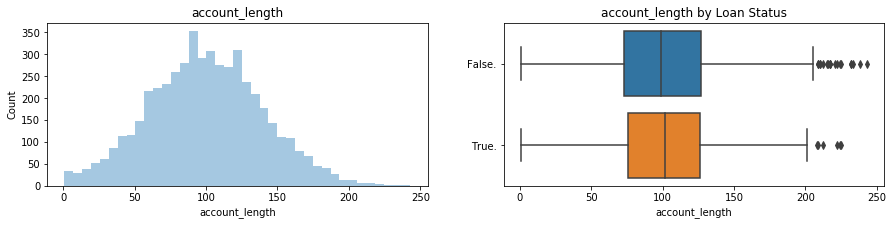

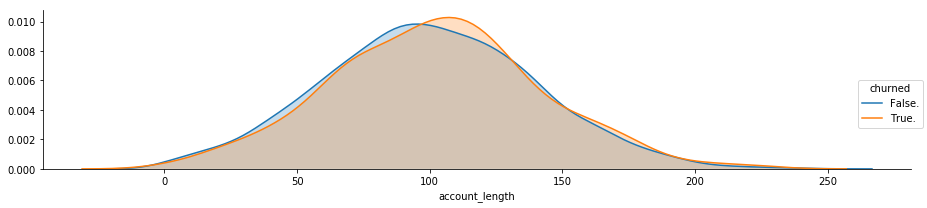

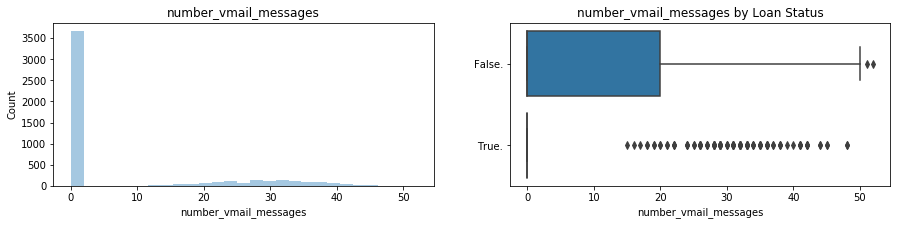

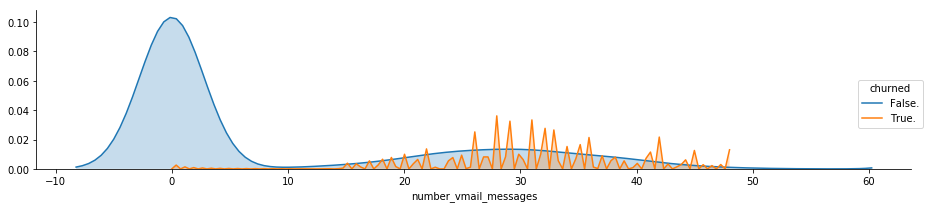

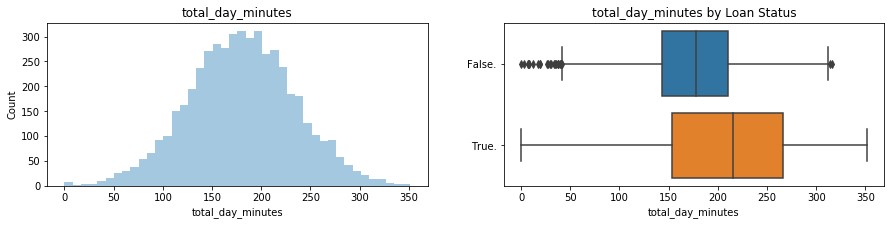

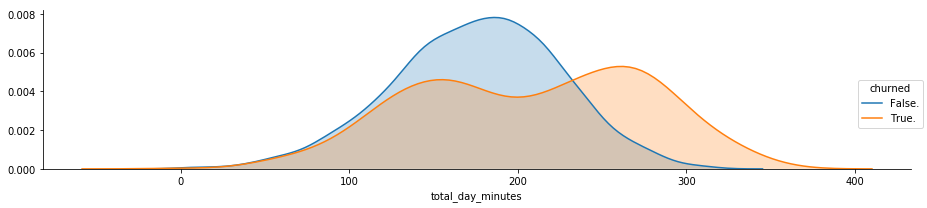

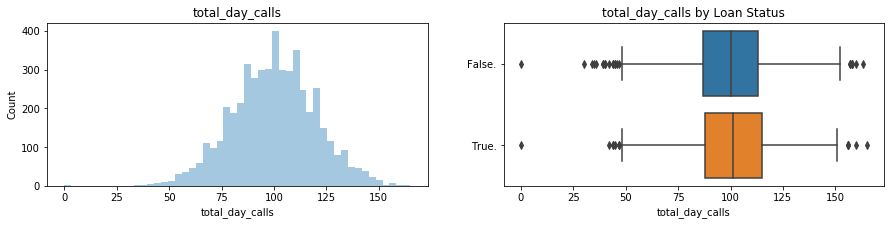

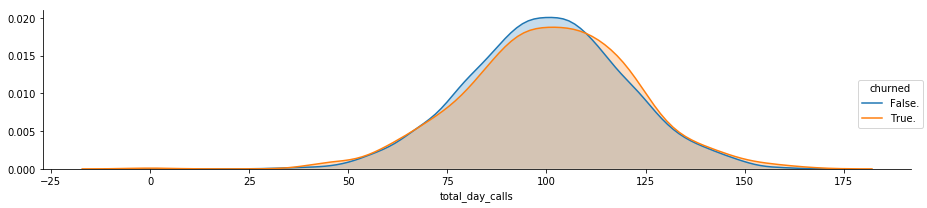

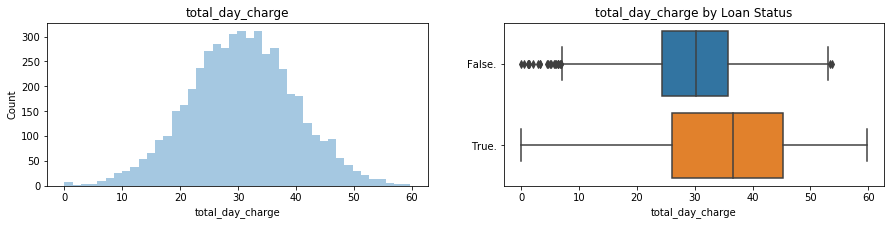

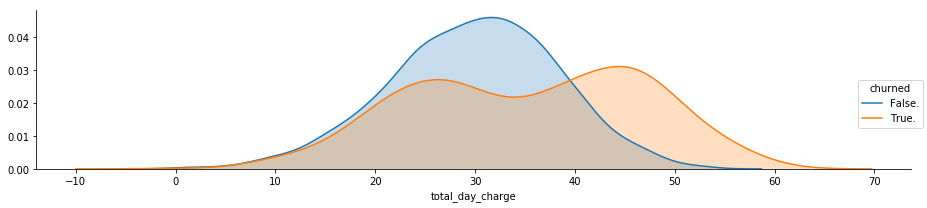

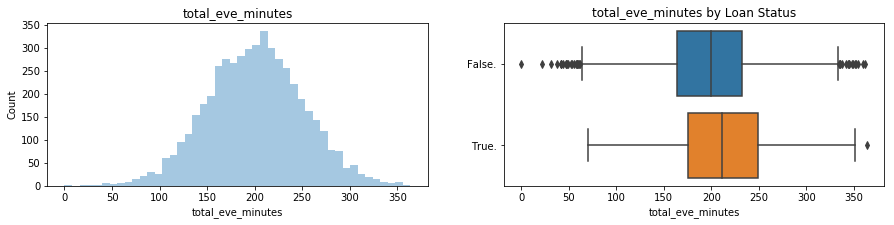

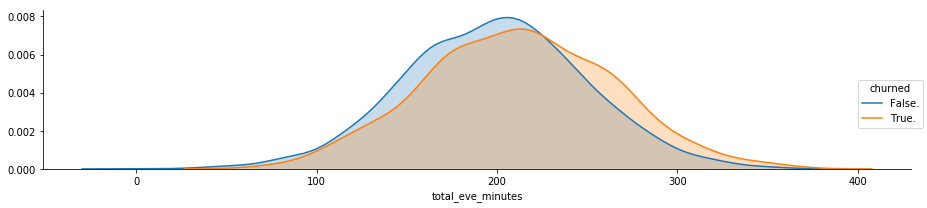

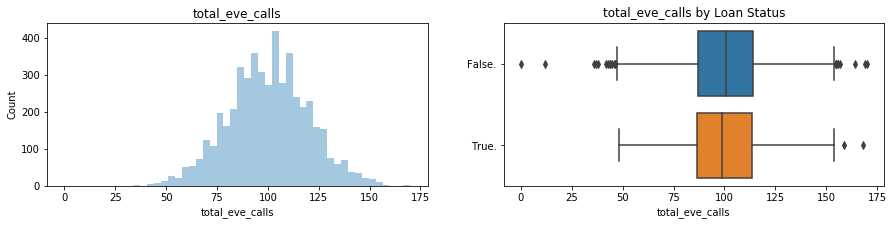

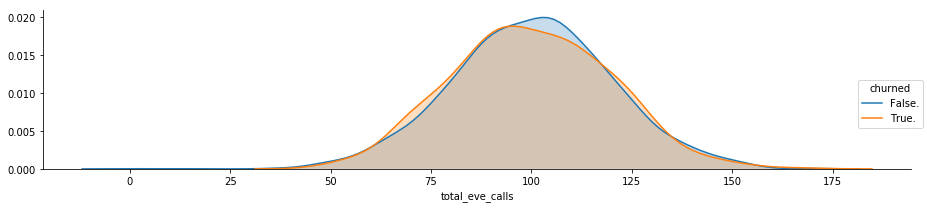

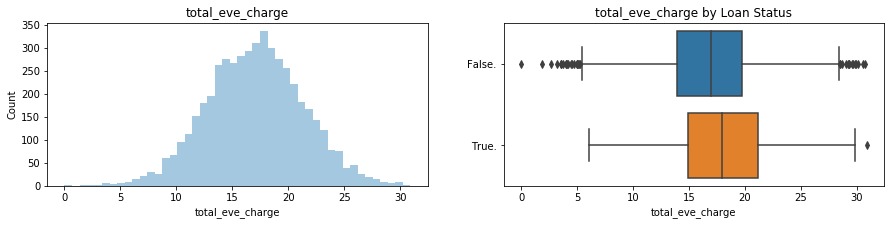

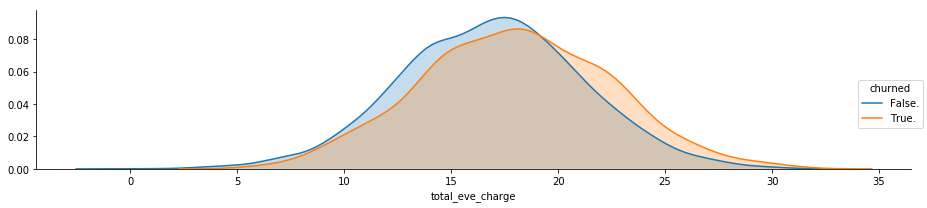

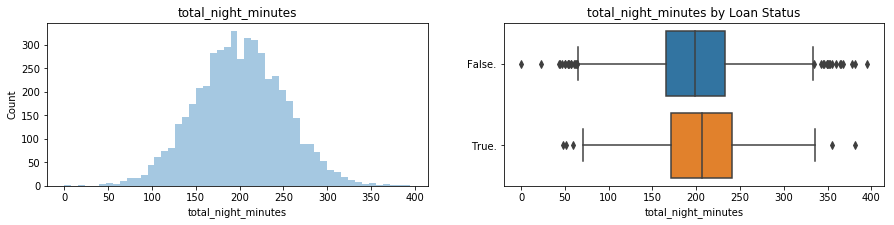

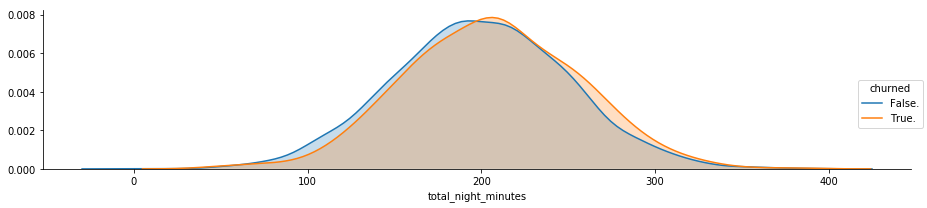

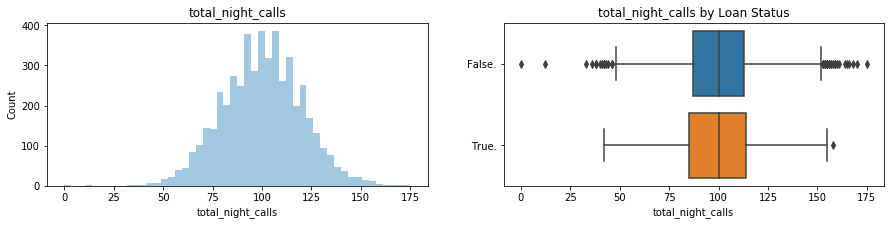

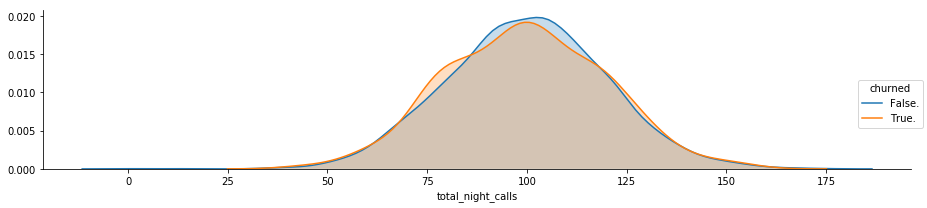

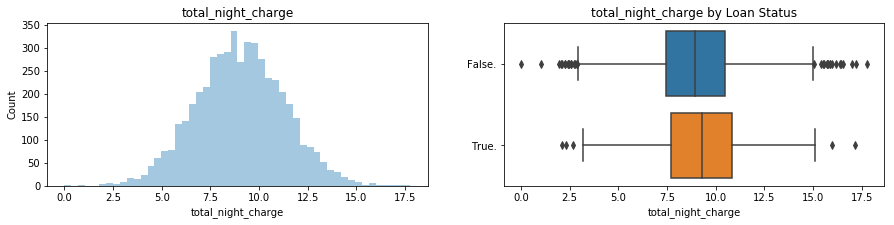

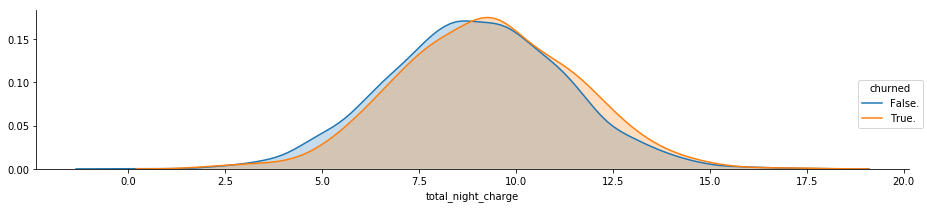

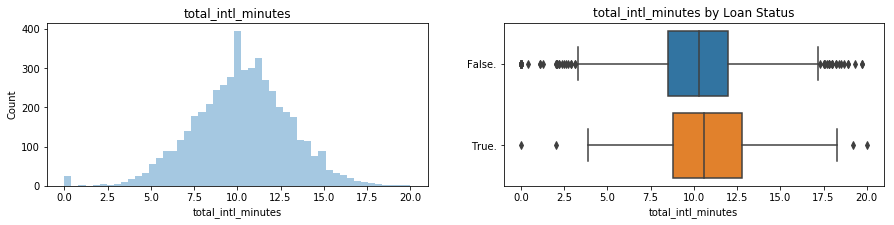

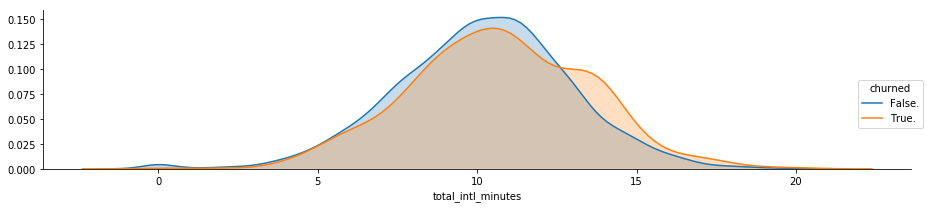

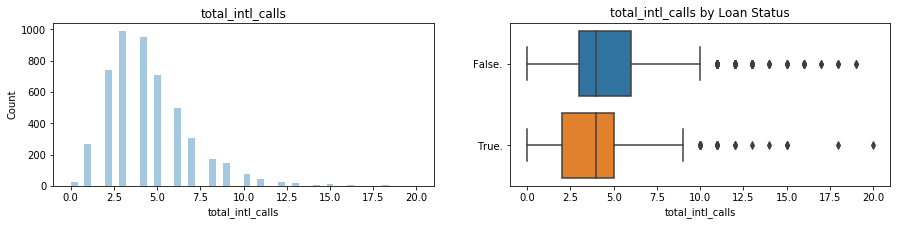

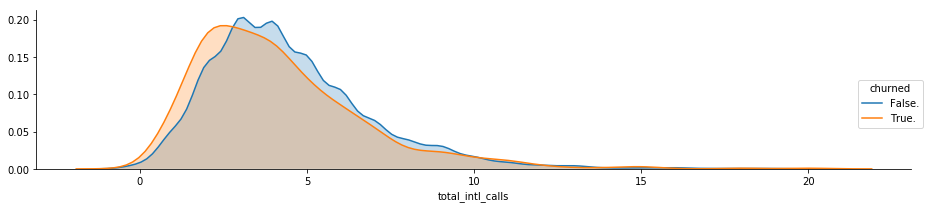

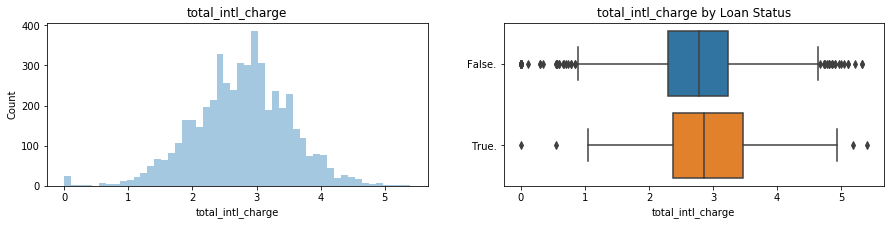

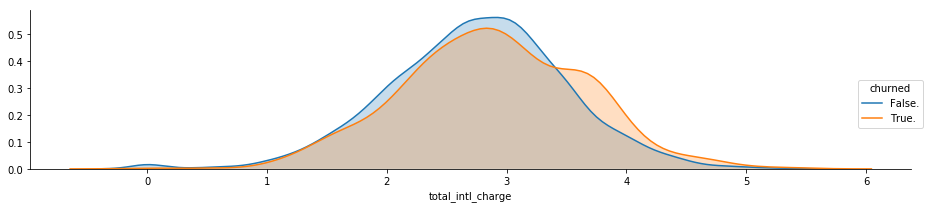

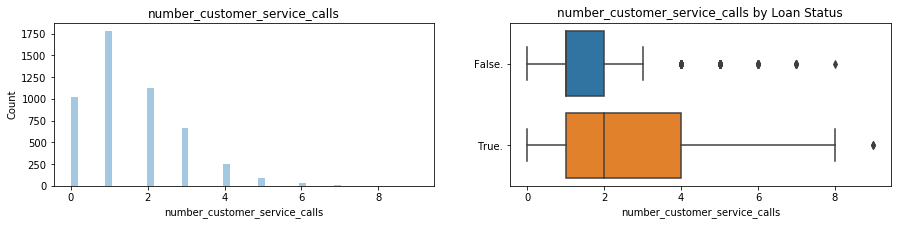

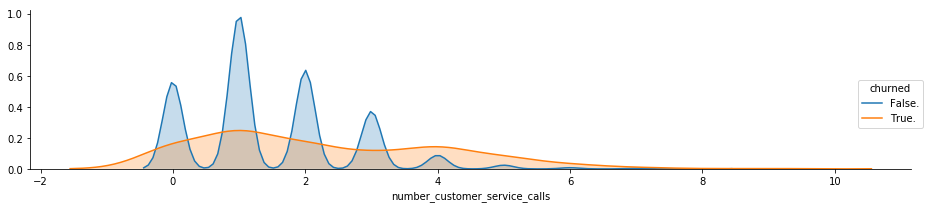

In [25]:
for plot_element in ks_list:
    plot_var(plot_element, plot_element, continuous=True)

I now have an idea about how each feature behaves for churned/stayed customers. 
I will check the correlation between features and with the target variable. 

#### Linear Correlation 

In [26]:
df.churned = df.churned.map({'False.':0, 'True.':1})

In [27]:
corr = df.drop(['area_code'], axis=1).corr()
#corr

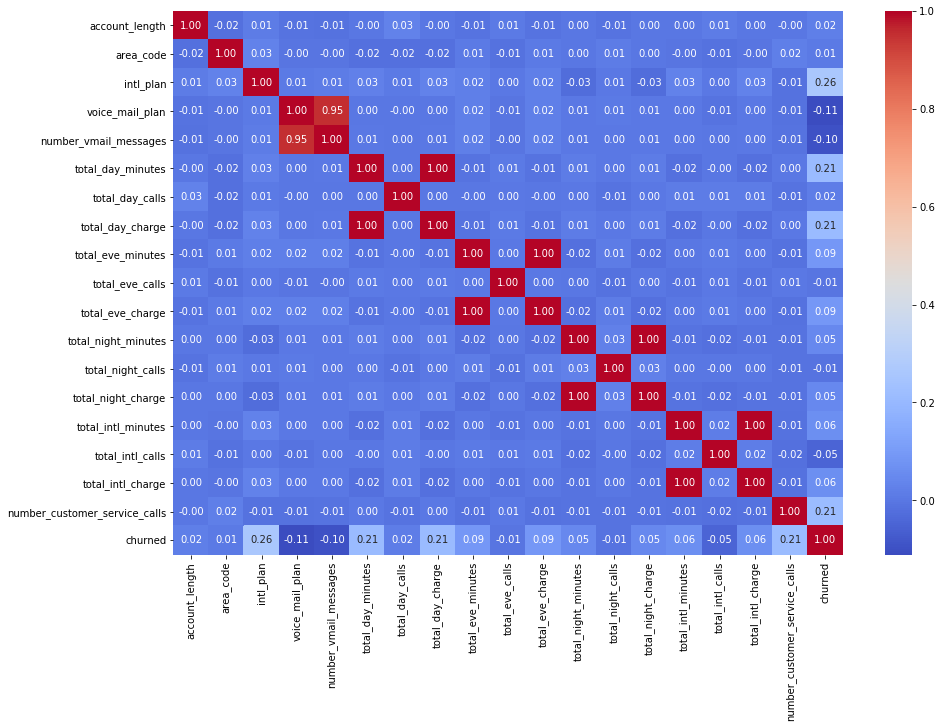

In [28]:
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
cm_df = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

I visualize the linear correlations in a heatmap. We can see that: the call minutes and call charge are perfectly correlated. The features that are linearly correlated with churned are intl_plan and total_day_charge, and number_customer_service calls.

I will then remove redundant features. 

In [29]:
#from scipy.stats import pearsonr
#print(pearsonr(df['total_day_minutes'],df['number_vmail_messages'])[0])

# Part 2: Feature Preprocessing

In [30]:
df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [31]:
# Drop some useless columns
drop_list = ['state', 'account_length', 'total_day_calls', 'total_eve_calls', 'total_night_calls','total_day_minutes', 'total_eve_minutes','total_night_minutes','voice_mail_plan', 'area_code','phone_number','total_intl_minutes', 'total_intl_calls','churned']

In [32]:
X = df.drop(drop_list, axis=1)
y = df.churned.values

In [33]:
# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X.sample(5)

,intl_plan,number_vmail_messages,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,number_customer_service_calls
1474,0,0,19.18,13.32,11.23,4.40,0
763,0,35,31.76,22.19,14.30,4.05,0
3015,0,25,19.24,22.94,10.31,1.92,2
1199,0,33,39.41,19.80,9.31,2.05,1
1743,0,0,44.34,21.94,5.91,1.57,1


In [35]:
# imputing missing values

In [36]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X.columns)

print("Feature space holds %d observations and %d features" % X_train.shape)
print("Unique target labels:", np.unique(y_train))

Feature space holds 4000 observations and 7 features
Unique target labels: [0 1]


# Part 3: Model Training and Result Evaluation
I will implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:

- Mean imputation of missing values
- Dimension reduction using linear discriminant analysis (LDA)
- Data standardization: rescaling to zero mean and unit variance
- The chosen model

I will evaluate and compare the following models using a cross-validated Area Under the Receiver Operating Characteristic Curve (AUROC)** score on the training set

I'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

** For the metrics, both precision and recall of the result are important, as we care about true positives as well as false positives. I like to predict most of the customers that are likely to churn and provide them some special offers but I don't want to bother the ones that actually are not going to stop using the service. 

In [37]:
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import  XGBClassifier

### Part 3.1: K-fold Cross-Validation

I compare 11 of the most popular classifiers and evaluate their performance using a stratified kfold cross validation procedure.

- Logistic Regression
- Linear Discriminant Analysis
- SVC
- KNN
- Random Forest (RFC)
- Decision Tree
- Extra Trees (ExtC)
- AdaBoost (Ada)
- Gradient Boosting (GBC)
- Multiple layer perceptron (neural network)
- XGBoost

In [38]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

/Users/yanxia/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


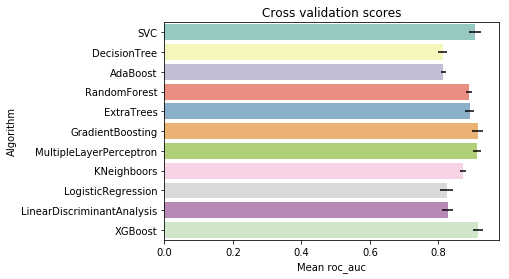

In [39]:
# Test differents algorithms 
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBoost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean roc_auc")
g = g.set_title("Cross validation scores")


I decide to choose: SVC, RandomForest, GradientBoosting, KNN and logistic Regression, XGBoost, for further fine-tunning and the ensemble modeling

### Part 3.2: Hyperparameter tunning for best models
grid search optimization for the classifiers

#### SVM

In [40]:
### SVC classifier
svm = SVC(probability=True)
svm_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

grid_svm = GridSearchCV(svm, param_grid = svm_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_svm.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [41]:
svm_best = grid_svm.best_estimator_
# Best score
print('Best Score:', grid_svm.best_score_)
print('Best parameters set: \n', grid_svm.best_params_)

Best Score: 0.9070896685031267
Best parameters set: 
 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [42]:
y_pred_svm = svm_best.predict(X_test)
y_prob_svm = svm_best.predict_proba(X_test)[:,1]

#### Random Forest

In [43]:
### SVC classifier
rf = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=42)
svm_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
rf_param_grid = {
    "max_features": range(2,7),
    "min_samples_split": range(4,10),
    "min_samples_leaf": range(1,6),
}

grid_rf = GridSearchCV(rf, param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   44.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(2, 7), 'min_samples_split': range(4, 10), 'min_samples_leaf': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [44]:
rf_best = grid_rf.best_estimator_
# Best score
print('Best Score:', grid_rf.best_score_)
print('Best parameters set: \n', grid_rf.best_params_)

Best Score: 0.9145490302448309
Best parameters set: 
 {'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 4}


In [45]:
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)[:,1]

#### KNN

In [46]:
### KNN classifier
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors':[4,8,16],
    'weights': ['uniform','distance']
}

grid_knn = GridSearchCV(knn, param_grid = knn_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_knn.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [4, 8, 16], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [47]:
knn_best = grid_knn.best_estimator_
# Best score
print('Best Score:', grid_knn.best_score_)
print('Best parameters set: \n', grid_knn.best_params_)

Best Score: 0.9085381396270955
Best parameters set: 
 {'n_neighbors': 16, 'weights': 'uniform'}


In [48]:
y_pred_knn = knn_best.predict(X_test)
y_prob_knn = knn_best.predict_proba(X_test)[:,1]

#### Logistic Regression 

In [49]:
### Logistic Regression classifier

lr = LogisticRegression()
C_grid = 0.001*10**(np.arange(0,1.01,0.01)*3)
lr_param_grid  = {
    'penalty': ['l1', 'l2'], 
    'C': C_grid
}

grid_lr = GridSearchCV(lr, lr_param_grid, scoring='roc_auc')
grid_lr.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([0.001  , 0.00107, ..., 0.93325, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
lr_best = grid_lr.best_estimator_
# Best score
print('Best Score:', grid_lr.best_score_)
print('Best parameters set: \n', grid_lr.best_params_)

Best Score: 0.8254500048075707
Best parameters set: 
 {'C': 0.003019951720402016, 'penalty': 'l2'}


In [51]:
y_pred_lr = lr_best.predict(X_test)
y_prob_lr = lr_best.predict_proba(X_test)[:,1]

#### Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

#### First I will compare Feature Coefficients

In [52]:
LRmodel_l1 = LogisticRegression(penalty="l1")
LRmodel_l1.fit(X_train, y_train)
LRmodel_l1.coef_[0]
print("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]),X_train.columns), key=lambda kv:(-abs(kv[0]),kv[1])):
    print(v + ": " + str(k))

Logistic Regression (L1) Coefficients
total_day_charge: 0.7139
number_customer_service_calls: 0.6919
intl_plan: 0.6115
number_vmail_messages: -0.401
total_eve_charge: 0.3524
total_intl_charge: 0.2314
total_night_charge: 0.1926


In [53]:
LRmodel_l2 = LogisticRegression(penalty="l2")
LRmodel_l2.fit(X_train, y_train)
LRmodel_l2.coef_[0]
print("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      X_train.columns), key=lambda kv:(-abs(kv[0]),kv[1
])):
    print(v + ": " + str(k))

Logistic Regression (L2) Coefficients
total_day_charge: 0.7136
number_customer_service_calls: 0.6919
intl_plan: 0.6116
number_vmail_messages: -0.4023
total_eve_charge: 0.3538
total_intl_charge: 0.2331
total_night_charge: 0.1944


####  Use Recursive Feature Elimination (RFE)

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

In [54]:
from sklearn.feature_selection import RFE

rfe_l1 = RFE(LRmodel_l1, n_features_to_select=1) # If None, half of the features are selected.
rfe_l1.fit(X_train, y_train)
print("Logistic Regression (L1) RFE Result")
for k,v in sorted(zip(map(lambda x: round(x, 4), rfe_l1.ranking_), X_train.columns)):
    print(v + ": " + str(k))

Logistic Regression (L1) RFE Result
total_day_charge: 1
number_customer_service_calls: 2
intl_plan: 3
number_vmail_messages: 4
total_eve_charge: 5
total_intl_charge: 6
total_night_charge: 7


In [55]:
from sklearn.feature_selection import RFE
rfe_l2 = RFE(LRmodel_l2, n_features_to_select=1) # If None, half of the features are selected.
rfe_l2.fit(X_train, y_train)
print("Logistic Regression (L2) RFE Result")
for k,v in sorted(zip(map(lambda x: round(x, 4), rfe_l2.ranking_), X_train.columns)):
    print(v + ": " + str(k))

Logistic Regression (L2) RFE Result
total_day_charge: 1
number_customer_service_calls: 2
intl_plan: 3
number_vmail_messages: 4
total_eve_charge: 5
total_intl_charge: 6
total_night_charge: 7


#### Gradient Boosting

In [56]:
# Gradient boosting tunning
gb = GradientBoostingClassifier(random_state=random_state)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

grid_gb = GridSearchCV(gb,param_grid = gb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_gb.fit(X_train,y_train)



Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 233 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   42.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [57]:
gb_best = grid_gb.best_estimator_
# Best score
print('Best Score:', grid_gb.best_score_)
print('Best parameters set: \n', grid_gb.best_params_)

Best Score: 0.915049361108592
Best parameters set: 
 {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 300}


In [58]:
y_pred_gb = gb_best.predict(X_test)
y_prob_gb = gb_best.predict_proba(X_test)[:,1]

#### XGBoost

In [59]:
# XGboost tunning
xgb = GradientBoostingClassifier(random_state=random_state)

#xgb.get_params().keys()
xgb_param_grid = {
    'learning_rate': [0.025,0.05,0.1], 
    'max_depth': [3,4,5],
    'subsample': [0.25,0.5,1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid = xgb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   11.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'learning_rate': [0.025, 0.05, 0.1], 'max_depth': [3, 4, 5], 'subsample': [0.25, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [60]:
xgb_best = grid_xgb.best_estimator_
# Best score
print('Best Score:', grid_xgb.best_score_)
print('Best parameters set: \n', grid_xgb.best_params_)

Best Score: 0.916059949862511
Best parameters set: 
 {'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.25}


In [61]:
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:,1]

In [62]:
# print a summary of the scores
def print_grid_search_metrics(gs):
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Part 3.3: Comparing the best models
I will take a closer look of the selected models: logistic Regression, Random Forest, Gradient Boosting, KNN, XGBoost and SVM. 

- Learning Curve
- Confusion Matrix

In [63]:
"""
print_grid_search_metrics(grid_svm)
print_grid_search_metrics(grid_rf)
print_grid_search_metrics(grid_gb)
print_grid_search_metrics(grid_knn)
print_grid_search_metrics(grid_lr)
print_grid_search_metrics(grid_xgb)
"""

'\nprint_grid_search_metrics(grid_svm)\nprint_grid_search_metrics(grid_rf)\nprint_grid_search_metrics(grid_gb)\nprint_grid_search_metrics(grid_knn)\nprint_grid_search_metrics(grid_lr)\nprint_grid_search_metrics(grid_xgb)\n'

#### Plot learning curves
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

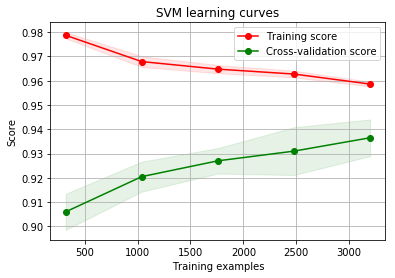

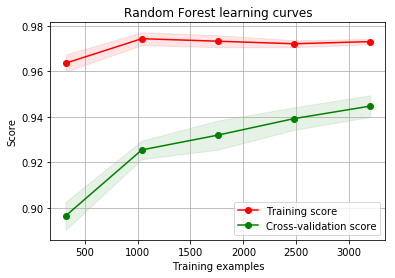

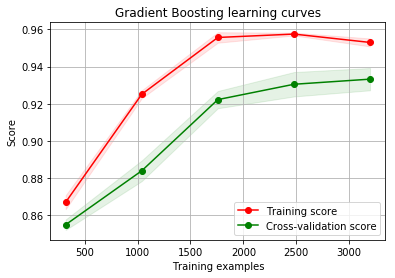

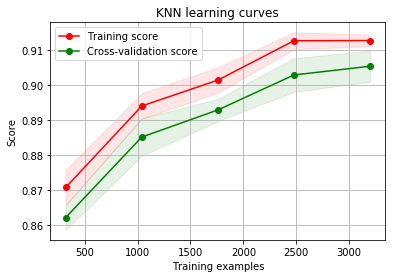

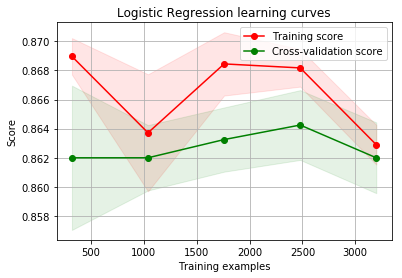

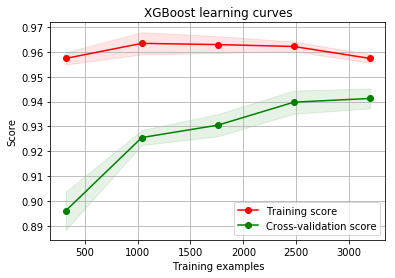

In [64]:
# Plot learning curves
#grid_svm, grid_rf, grid_gb, grid_knn, grid_lr, grid_xgb

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(grid_svm.best_estimator_,"SVM learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_rf.best_estimator_,"Random Forest learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_gb.best_estimator_,"Gradient Boosting learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_knn.best_estimator_,"KNN learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_lr.best_estimator_,"Logistic Regression learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(grid_xgb.best_estimator_,"XGBoost learning curves",X_train,y_train,cv=kfold)

GradientBoosting, KNN, Random Forest tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and XGBoost classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

#### Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [65]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

def cal_evaluation(classifier, cm, auc):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2 * precision * recall / (precision + recall)
    print(classifier)
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1 score is " + str(f1))
    print("ROC AUC is " + str(auc))

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        cal_evaluation(classifier, cm, auc)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for {}'.format(classifier))
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

[0 1]
Gradient Boosting
Accuracy is 0.944
Precision is 0.9191919191919192
Recall is 0.6546762589928058
F1 score is 0.7647058823529412
ROC AUC is 0.9081877355258651


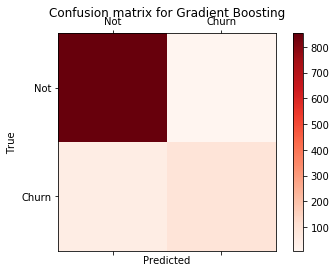

Logisitic Regression
Accuracy is 0.871
Precision is 0.631578947368421
Recall is 0.17266187050359713
F1 score is 0.2711864406779661
ROC AUC is 0.8285580594757643


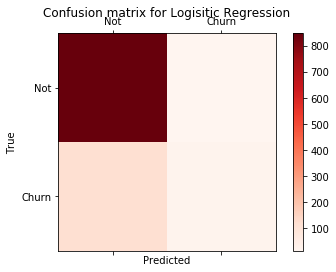

K-Nearest-Neighbors
Accuracy is 0.915
Precision is 0.95
Recall is 0.41007194244604317
F1 score is 0.5728643216080402
ROC AUC is 0.8919985962449553


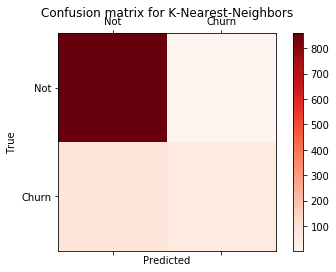

Random Forest
Accuracy is 0.943
Precision is 0.8942307692307693
Recall is 0.6690647482014388
F1 score is 0.7654320987654322
ROC AUC is 0.8994978233441122


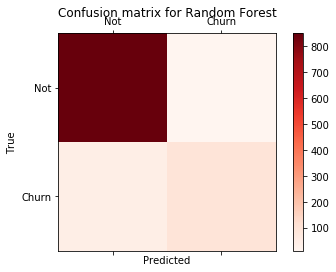

Support Vector Machine
Accuracy is 0.943
Precision is 0.8867924528301887
Recall is 0.6762589928057554
F1 score is 0.7673469387755103
ROC AUC is 0.9090817937984108


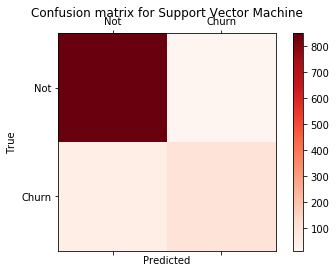

XGBoost Classifier
Accuracy is 0.947
Precision is 0.9056603773584906
Recall is 0.6906474820143885
F1 score is 0.7836734693877552
ROC AUC is 0.9108740881858972


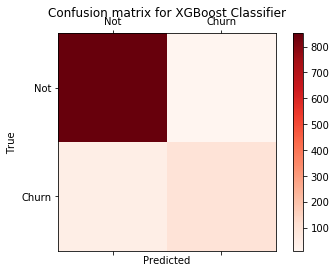

In [66]:
%matplotlib inline

y = np.array(y)
class_names = np.unique(y)
print(class_names)

confusion_matrices = [
    ("Gradient Boosting", confusion_matrix(y_test, y_pred_gb), roc_auc_score(y_test, y_prob_gb)),
    ("Logisitic Regression", confusion_matrix(y_test, y_pred_lr), roc_auc_score(y_test, y_prob_lr)),
    ("K-Nearest-Neighbors", confusion_matrix(y_test, y_pred_knn), roc_auc_score(y_test, y_prob_knn)),
    ("Random Forest", confusion_matrix(y_test, y_pred_rf), roc_auc_score(y_test, y_prob_rf)),
    ("Support Vector Machine", confusion_matrix(y_test, y_pred_svm), roc_auc_score(y_test, y_prob_svm)),
    ("XGBoost Classifier", confusion_matrix(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb))
    
]

draw_confusion_matrices(confusion_matrices)

#### Feature importance of tree based classifiers
In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the tree based classifiers.

In [67]:
"""
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
importances = forest.feature_importances_
# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True):
    print(v + ": " + str(k))
"""

'\nforest = RandomForestClassifier()\nforest.fit(X_train, y_train)\nimportances = forest.feature_importances_\n# Print the feature ranking\nprint("Feature importance ranking by Random Forest Model:")\nfor k,v in sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True):\n    print(v + ": " + str(k))\n'

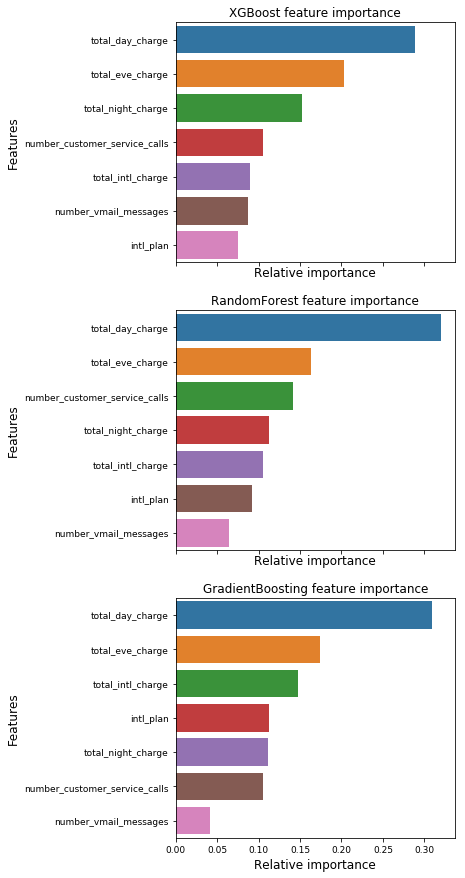

In [68]:
#nrows = ncols = 2
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(5,15))

names_classifiers = [("XGBoost", xgb_best),("RandomForest",rf_best),("GradientBoosting",gb_best),("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

I plot the feature importance for the 3 tree based classifiers (Random Forest, Gradient Boosting and XGBoost)

I note that the four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example "total_day_charge", "total_eve_charge". 


It is not unexpected that the more important features are the charge of the calls, as the customers who spend more money are more likely to drop and switch to other cell phone service providers. For the Random Forest, the number of customer service calls is also quite important and is ranked at the third. This makes sense since the users who called the customer service more tend to have more problems and are likely to drop as well.

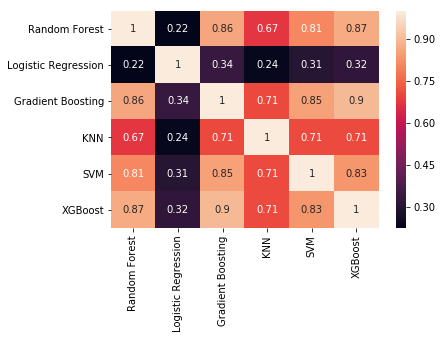

In [69]:
# Concatenate all classifier results

test_rf = pd.Series(rf_best.predict(X_test), name="Random Forest")
test_lr = pd.Series(lr_best.predict(X_test), name="Logistic Regression")
test_gb = pd.Series(gb_best.predict(X_test), name="Gradient Boosting")
test_knn = pd.Series(knn_best.predict(X_test), name="KNN")
test_svm = pd.Series(svm_best.predict(X_test), name="SVM")
test_xgb = pd.Series(xgb_best.predict(X_test), name="XGBoost")


ensemble_results = pd.concat([test_rf, test_lr,test_gb,test_knn, test_svm, test_xgb],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

The prediction seems to be quite similar for the 6 classifiers except when Logistic Regresion is compared to the others classifiers.

The 6 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

### Ensemble modeling

I chosed a voting classifier to combine the predictions coming from the 6 classifiers.

I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [70]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('lr',lr_best),('knn', knn_best),
('svm', svm_best), ('gb',gb_best),('xgb',xgb_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, y_train)

In [71]:
y_pred_voting = votingC.predict(X_test)
y_prob_voting = votingC.predict_proba(X_test)[:,1]

/Users/yanxia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Ensemble modeling
Accuracy is 0.947
Precision is 0.967391304347826
Recall is 0.6402877697841727
F1 score is 0.7705627705627704
ROC AUC is 0.9084551174391498


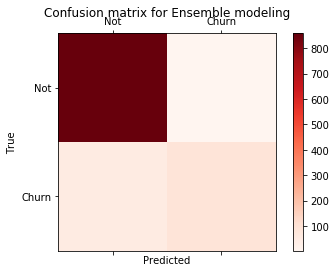

In [72]:
confusion_matrices = [
    ("Ensemble modeling", confusion_matrix(y_test, y_pred_voting), roc_auc_score(y_test, y_prob_voting))   
]
draw_confusion_matrices(confusion_matrices)

The AUROC score of 0.9092 is smaller than the XGBoost score of 0.9109. Therefore, I will use XGboost for the final prediction. 

## XGBoost for predictions
Again, the goal is to predict user churn. 

I will display the XGBoost results below, as a reminder. 

XGboost
Accuracy is 0.947
Precision is 0.9056603773584906
Recall is 0.6906474820143885
F1 score is 0.7836734693877552
ROC AUC is 0.9108740881858972


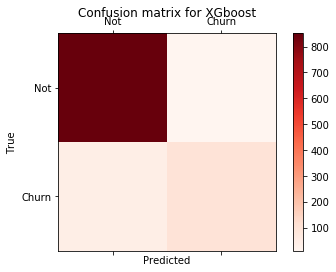

In [73]:
confusion_matrices = [
    ("XGboost", confusion_matrix(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb))
]

draw_confusion_matrices(confusion_matrices)

Next, I will try to determine the optimal threshold. As true positive rate and recall are actually equal, therefore, one can use a lower threshold(<0.5) to achieve higher recall rate.

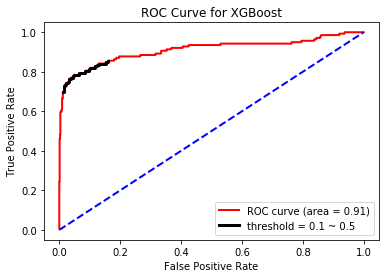

In [74]:
# make the ROC curve
fpr, tpr, thresh = roc_curve(y_test, y_prob_xgb, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob_xgb)

# These are the points at threshold = 0.1~0.5
x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

fig = plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

I will check how different evaluation metrics change with the threshold 

In [75]:
acc_grid = np.zeros(thresh.shape)
prec_grid = np.zeros(thresh.shape)
recall_grid = np.zeros(thresh.shape)
TP_grid = np.zeros(thresh.shape)
FP_grid = np.zeros(thresh.shape)
FN_grid = np.zeros(thresh.shape)

for i in range(thresh.shape[0]):
    cm = confusion_matrix(y_test, y_prob_xgb >= thresh[i])
    acc_grid[i] = accuracy_score(y_test, y_prob_xgb >= thresh[i])
    prec_grid[i] = precision_score(y_test, y_prob_xgb >= thresh[i])
    recall_grid[i] = recall_score(y_test, y_prob_xgb >= thresh[i])
    TP_grid[i] = cm[1][1]
    FP_grid[i] = cm[0][1]
    FN_grid[i] = cm[1][0]

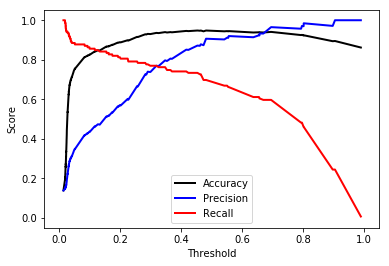

In [76]:
fig = plt.figure()
plt.plot(thresh, acc_grid, color='k', lw=2, label='Accuracy')
plt.plot(thresh, prec_grid, color='b', lw=2, label='Precision')
plt.plot(thresh, recall_grid, color='r', lw=2, label='Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc="lower center")
plt.show()


There is a trade-off between precision and recall, therefore we need to set a goal and fine-tune the threshold of the XGBoost model. In this problem, the goal is to minimize the loss of profitability. As mentioned earlier, I want to provide the customers who will likely to stop the service with a special offer, in order to prevent their drops. However, we would make additional cost if we falsely target a customer who actually won't stop using the service.

In the following, we use a very simple method to estimate the loss of our profitability:

- If a customer stop the service, we lose 1 point
- If a customer takes the special offer we provide and continue using the service, we lose 0.1 point
- If we do nothing and a customer continue using the service, we lose nothing and get 0 point

We assume that half of the customers who were going to drop will take the offer, and all the the customers who were not going to drop will take the offer.
Note that these are just my assumptions for a case study. In the reality, the company would have to carefully estimate these numbers. 

We can inspect how the loss changes with the threshold we use as follows.

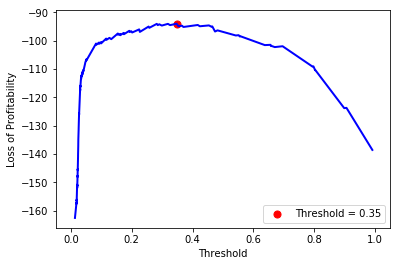

In [77]:
P = 0.5 # The chance a customer who was going to drop would take the special offer
loss = TP_grid*P*(-0.1) + TP_grid*(1-P)*(-1) + FN_grid*(-1) + FP_grid*(-0.1)
thresh_best = thresh[loss == max(loss)][0]
    
fig = plt.figure()
plt.plot(thresh, loss, color='b', lw=2)
plt.scatter([thresh_best], [max(loss)], color='r', s=50, label='Threshold = {:.2f}'.format(thresh_best))
plt.xlim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Loss of Profitability')
plt.legend(loc="lower right")
plt.show()


We see that the loss is minimized at threshold = 0.35. Now let's take a look at the confusion matrix using this threshold.

XGboost
Accuracy is 0.939
Precision is 0.7954545454545454
Recall is 0.7553956834532374
F1 score is 0.7749077490774907
ROC AUC is 0.9108740881858972


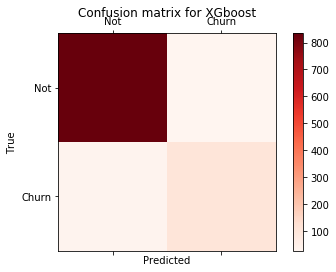

In [78]:
y_pred_xgb_new = y_prob_xgb > thresh_best

confusion_matrices = [
    ("XGboost", confusion_matrix(y_test, y_pred_xgb_new), roc_auc_score(y_test, y_prob_xgb))
]

draw_confusion_matrices(confusion_matrices)